# TensorNetworks in Neural Networks.

Here, we have a small toy example of how to use a TN inside of a fully connected neural network.

First off, let's install tensornetwork

In [46]:
# !pip install tensornetwork

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# Import tensornetwork
import tensornetwork as tn
# Set the backend to tesorflow
# (default is numpy)
tn.set_default_backend("tensorflow")
import time

# TensorNetwork layer definition

Here, we define the TensorNetwork layer we wish to use to replace the fully connected layer. Here, we simply use a 2 node Matrix Product Operator network to replace the normal dense weight matrix.

We TensorNetwork's NCon API to keep the code short.

In [47]:
class TNLayer(tf.keras.layers.Layer):

  def __init__(self):
    super(TNLayer, self).__init__()
    # Create the variables for the layer.
    self.a_var = tf.Variable(tf.random.normal(shape=(32, 32, 8),
                                              stddev=1.0/32.0),
                             name="a", trainable=True)
    self.b_var = tf.Variable(tf.random.normal(shape=(32, 32, 8),
                                              stddev=1.0/32.0),
                             name="b", trainable=True)
    self.bias = tf.Variable(tf.zeros(shape=(32, 32)),
                            name="bias", trainable=True)

  def call(self, inputs):
    # Define the contraction.
    # We break it out so we can parallelize a batch using
    # tf.vectorized_map (see below).
    def f(input_vec, a_var, b_var, bias_var):
      # Reshape to a matrix instead of a vector.
      input_vec = tf.reshape(input_vec, (32, 32))

      # Now we create the network.
      a = tn.Node(a_var)
      b = tn.Node(b_var)
      x_node = tn.Node(input_vec)
      a[1] ^ x_node[0]
      b[1] ^ x_node[1]
      a[2] ^ b[2]

      # The TN should now look like this
      #   |     |
      #   a --- b
      #    \   /
      #      x

      # Now we begin the contraction.
      c = a @ x_node
      result = (c @ b).tensor

      # To make the code shorter, we also could've used Ncon.
      # The above few lines of code is the same as this:
      # result = tn.ncon([x, a_var, b_var], [[1, 2], [-1, 1, 3], [-2, 2, 3]])

      # Finally, add bias.
      return result + bias_var

    # To deal with a batch of items, we can use the tf.vectorized_map
    # function.
    # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
    result = tf.vectorized_map(
        lambda vec: f(vec, self.a_var, self.b_var, self.bias), inputs)
    return tf.nn.relu(tf.reshape(result, (-1, 1024)))

# Smaller model
These two models are effectively the same, but notice how the TN layer has nearly 10x fewer parameters.

In [48]:
Dense = tf.keras.layers.Dense
fc_model = tf.keras.Sequential(
    [
     tf.keras.Input(shape=(2,)),
     Dense(1024, activation=tf.nn.relu),
     Dense(1024, activation=tf.nn.relu),
     Dense(1, activation=None)])
fc_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 1024)              3072      
                                                                 
 dense_26 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_27 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 1053697 (4.02 MB)
Trainable params: 1053697 (4.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
tn_model = tf.keras.Sequential(
    [
     tf.keras.Input(shape=(2,)),
     Dense(1024, activation=tf.nn.relu),
     # Here, we replace the dense layer with our MPS.
     TNLayer(),
     Dense(1, activation=None)])
tn_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 1024)              3072      
                                                                 
 tn_layer_5 (TNLayer)        (None, 1024)              17408     
                                                                 
 dense_29 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 21505 (84.00 KB)
Trainable params: 21505 (84.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training a model

You can train the TN model just as you would a normal neural network model! Here, we give an example of how to do it in Keras.

In [50]:
X = np.concatenate([np.random.randn(20, 2) + np.array([3, 3]),
                    np.random.randn(20, 2) + np.array([-3, -3]),
                    np.random.randn(20, 2) + np.array([-3, 3]),
                    np.random.randn(20, 2) + np.array([3, -3])])

Y = np.concatenate([np.ones((40)), -np.ones((40))])

In [51]:
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1709451406.3962114
Sun Mar  3 07:36:46 2024


In [52]:
tn_model.compile(optimizer="adam", loss="mean_squared_error")
tn_model.fit(X, Y, epochs=600, verbose=2)

Epoch 1/600
3/3 - 1s - loss: 0.9664 - 1s/epoch - 344ms/step
Epoch 2/600
3/3 - 0s - loss: 0.8260 - 15ms/epoch - 5ms/step
Epoch 3/600
3/3 - 0s - loss: 0.7018 - 15ms/epoch - 5ms/step
Epoch 4/600
3/3 - 0s - loss: 0.5751 - 15ms/epoch - 5ms/step
Epoch 5/600
3/3 - 0s - loss: 0.4407 - 15ms/epoch - 5ms/step
Epoch 6/600
3/3 - 0s - loss: 0.3030 - 15ms/epoch - 5ms/step
Epoch 7/600
3/3 - 0s - loss: 0.1849 - 15ms/epoch - 5ms/step
Epoch 8/600
3/3 - 0s - loss: 0.1112 - 16ms/epoch - 5ms/step
Epoch 9/600
3/3 - 0s - loss: 0.0995 - 16ms/epoch - 5ms/step
Epoch 10/600
3/3 - 0s - loss: 0.1178 - 15ms/epoch - 5ms/step
Epoch 11/600
3/3 - 0s - loss: 0.1115 - 15ms/epoch - 5ms/step
Epoch 12/600
3/3 - 0s - loss: 0.0908 - 16ms/epoch - 5ms/step
Epoch 13/600
3/3 - 0s - loss: 0.0827 - 15ms/epoch - 5ms/step
Epoch 14/600
3/3 - 0s - loss: 0.0832 - 16ms/epoch - 5ms/step
Epoch 15/600
3/3 - 0s - loss: 0.0813 - 17ms/epoch - 6ms/step
Epoch 16/600
3/3 - 0s - loss: 0.0771 - 16ms/epoch - 5ms/step
Epoch 17/600
3/3 - 0s - loss: 0.0

14/14 [==============================] - 0s 3ms/step


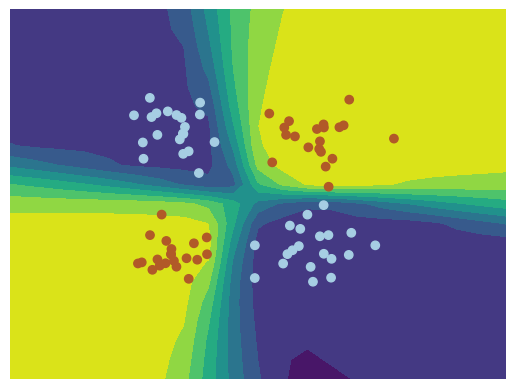

In [53]:
# Plotting code, feel free to ignore.
h = 1.0
x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# here "model" is your model's prediction (classification) function
Z = tn_model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)

In [54]:
seconds = time.time()
print("Time in seconds since end of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since end of run: 1709451418.7369456
Sun Mar  3 07:36:58 2024


In [55]:
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1709451418.749406
Sun Mar  3 07:36:58 2024


# VS Fully Connected

Epoch 1/600
3/3 - 1s - loss: 0.5219 - 654ms/epoch - 218ms/step
Epoch 2/600
3/3 - 0s - loss: 0.4422 - 25ms/epoch - 8ms/step
Epoch 3/600
3/3 - 0s - loss: 0.2115 - 22ms/epoch - 7ms/step
Epoch 4/600
3/3 - 0s - loss: 0.1783 - 24ms/epoch - 8ms/step
Epoch 5/600
3/3 - 0s - loss: 0.1227 - 27ms/epoch - 9ms/step
Epoch 6/600
3/3 - 0s - loss: 0.1307 - 29ms/epoch - 10ms/step
Epoch 7/600
3/3 - 0s - loss: 0.0885 - 26ms/epoch - 9ms/step
Epoch 8/600
3/3 - 0s - loss: 0.0987 - 27ms/epoch - 9ms/step
Epoch 9/600
3/3 - 0s - loss: 0.0948 - 27ms/epoch - 9ms/step
Epoch 10/600
3/3 - 0s - loss: 0.0684 - 27ms/epoch - 9ms/step
Epoch 11/600
3/3 - 0s - loss: 0.0827 - 25ms/epoch - 8ms/step
Epoch 12/600
3/3 - 0s - loss: 0.0805 - 29ms/epoch - 10ms/step
Epoch 13/600
3/3 - 0s - loss: 0.0755 - 26ms/epoch - 9ms/step
Epoch 14/600
3/3 - 0s - loss: 0.0696 - 27ms/epoch - 9ms/step
Epoch 15/600
3/3 - 0s - loss: 0.0717 - 30ms/epoch - 10ms/step
Epoch 16/600
3/3 - 0s - loss: 0.0750 - 24ms/epoch - 8ms/step
Epoch 17/600
3/3 - 0s - los

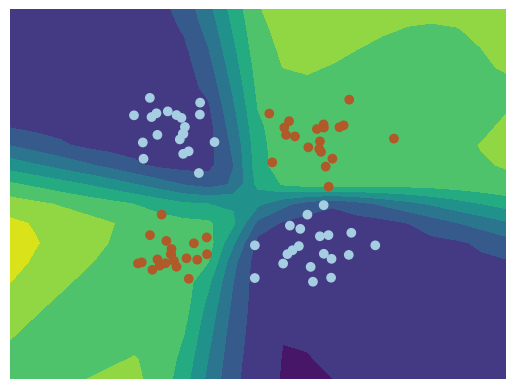

In [56]:
fc_model.compile(optimizer="adam", loss="mean_squared_error")
fc_model.fit(X, Y, epochs=600, verbose=2)
# Plotting code, feel free to ignore.
h = 1.0
x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# here "model" is your model's prediction (classification) function
Z = fc_model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)

In [57]:
seconds = time.time()
print("Time in seconds since end of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since end of run: 1709451437.0216527
Sun Mar  3 07:37:17 2024
